Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

Define Cutting Functions

In [2]:
def get_xyzq(event):
    '''
    Truncates the points in an event to only include x, y, z, and q
    '''
    try:
        xyzq = np.empty((len(event), 4))
        xyzq = np.stack((event[:, 0], event[:, 1], event[:, 2], event[:, 4]), axis=-1)
    except:
        xyzq = np.empty((len(event), 3))
        xyzq = np.stack((event[:, 0], event[:, 1], event[:, 2]), axis=-1)

    return xyzq


def restructure(event, fourD):
    '''
    Takes an event and sorts the points by Z
    '''

    if fourD:
        dtype = [('x', float), ('y', float), ('z', float), ('q', float)]
    else:
        dtype = [('x', float), ('y', float), ('z', float)]

    sorted = np.empty((len(event), ), dtype=dtype)

    xs = event[:, 0]
    ys = event[:, 1]
    zs = event[:, 2]
    if fourD:
        qs = event[:, 4]

    for i in range(len(event)):
        if fourD:
            sorted[i] = (xs[i], ys[i], zs[i], qs[i])
        else:
            sorted[i] = (xs[i], ys[i], zs[i])

    sorted = np.sort(sorted, order='z')

    return sorted


def revert(event):
    '''
    Undos the data restructuring by restructure func and shuffles points in event
    '''
    try:
        reverted = np.empty((1, len(event), 4))
        for i in range(len(event)):
            reverted[0, i, 0] = event[i]['x']
            reverted[0, i, 1] = event[i]['y']
            reverted[0, i, 2] = event[i]['z']
            reverted[0, i, 3] = event[i]['q']
    except:    
        reverted = np.empty((1, len(event), 3))
        for i in range(len(event)):
            reverted[0, i, 0] = event[i]['x']
            reverted[0, i, 1] = event[i]['y']
            reverted[0, i, 2] = event[i]['z']

    # np.random.default_rng().shuffle(reverted, axis=1)

    return reverted


def random_cut(event, nSliced):
    '''
    Randomly cuts nSliced points from event
    '''

    rng = np.random.default_rng()
    
    slice_idx = int(rng.random() * len(event))
    # Ensure no out of bounds indexing
    while slice_idx > (len(event) - nSliced):
        slice_idx = int(rng.random() * len(event))

    last_idx = slice_idx + nSliced

    return np.delete(event, np.s_[slice_idx:last_idx], axis=0)


def middle_cut(event, nSliced):
    '''
    Cuts out nSliced points from the middle of event
    '''
    
    low = len(event)//2 - nSliced//2
    high = low + nSliced
    assert low == len(event)//4 and high == 3*low, f'low == {low} -- high == {high}'

    return np.delete(event, np.s_[low:high], axis=0)


def half_cut(event):
    '''
    Cuts an event in half z wise
    '''

    return event[:len(event)//2]

Define Scaling/Visualizing Functions

In [3]:
def down_scale(event):
    '''
    Down scales event
    '''

    RANGES = {
            'MIN_X': -270.0,
            'MAX_X': 270.0,
            'MIN_Y': -270.0,
            'MAX_Y': 270.0,
            'MIN_Z': -185.0,
            'MAX_Z': 1155.0,
            'MIN_LOG_A': 0.0,
            'MAX_LOG_A': 8.60
        }
    
    event[:, 0] = (event[:, 0] - RANGES['MIN_X']) / (RANGES['MAX_X'] - RANGES['MIN_X'])
    event[:, 1] = (event[:, 1] - RANGES['MIN_Y']) / (RANGES['MAX_Y'] - RANGES['MIN_Y'])
    event[:, 2] = (event[:, 2] - RANGES['MIN_Z']) / (RANGES['MAX_Z'] - RANGES['MIN_Z'])
    try:
        event[:, 3] = (np.log(event[:, 3]) - RANGES['MIN_LOG_A'])/(RANGES['MAX_LOG_A'] - RANGES['MIN_LOG_A'])
    except:
        pass

    return event


def up_scale(event, scaleQ=True):
    '''
    Undos down_scale func
    '''

    RANGES = {
            'MIN_X': -270.0,
            'MAX_X': 270.0,
            'MIN_Y': -270.0,
            'MAX_Y': 270.0,
            'MIN_Z': -185.0,
            'MAX_Z': 1155.0,
            'MIN_LOG_A': 0.0,
            'MAX_LOG_A': 8.60
        }
    
    event[:, 0] = event[:, 0] * (RANGES['MAX_X'] - RANGES['MIN_X']) + RANGES['MIN_X']
    event[:, 1] = event[:, 1] * (RANGES['MAX_Y'] - RANGES['MIN_Y']) + RANGES['MIN_Y']
    event[:, 2] = event[:, 2] * (RANGES['MAX_Z'] - RANGES['MIN_Z']) + RANGES['MIN_Z']
    if scaleQ:
        event[:, 3] = np.exp(event[:, 3]) * (RANGES['MAX_Z'] - RANGES['MIN_Z']) + RANGES['MIN_Z']
    else:
        pass

    return event


def scaled_vis(event, showcolor=True):
    '''
    Makes a scatter plot with fixed AT-TPC axes, assumes up scaled event
    '''

    xs = event[:, 0]
    ys = event[:, 1]
    zs = event[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    try:
        if showcolor:
            qs = event[:, 3]
            sc = ax.scatter(xs, zs, ys, c=qs, cmap='jet', s=1)
            fig.colorbar(sc)
        else:
            ax.scatter(xs, zs, ys, s=1)
    except:
        ax.scatter(xs, zs, ys, s=1)
    ax.set_xlabel('X')
    ax.set_zlabel('Y')
    ax.set_ylabel('Z')

    RANGES = {
            'MIN_X': -270.0,
            'MAX_X': 270.0,
            'MIN_Y': -270.0,
            'MAX_Y': 270.0,
            'MIN_Z': -185.0,
            'MAX_Z': 1155.0
        }

    ax.set_xlim(xmin=RANGES['MIN_X'], xmax=RANGES['MAX_X'])
    ax.set_ylim(ymin=RANGES['MIN_Z'], ymax=RANGES['MAX_Z'])
    ax.set_zlim(zmin=RANGES['MIN_Y'], zmax=RANGES['MAX_Y'])

    plt.show()
    # plt.savefig('path.png')

    return


def unscaled_vis(event, showcolor=True):

    xs = event[:, 0]
    ys = event[:, 1]
    zs = event[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    try:
        if showcolor:
            qs = event[:, 3]
            sc = ax.scatter(xs, zs, ys, c=qs, s=1,  cmap='jet')
            fig.colorbar(sc)
        else:
            ax.scatter(xs, zs, ys, s=1)
    except:
        ax.scatter(xs, zs, ys)
    ax.set_xlabel('X')
    ax.set_zlabel('Y')
    ax.set_ylabel('Z')

    plt.show()

    return


Define files to cut, numbers of points to cut, number of cuts, and what kind of cut

In [4]:
os.getcwd()

'/home/DAVIDSON/taawal/ATTPCPoinTr/ATTPCPoinTr/data'

In [10]:
# Set Cutting Parameters
nComplete = 512
nCut = 128
num_cuts = 4

# Set Cut Type
rand = True
mid = False
if mid:
    assert num_cuts == 1, 'Middle cutting requires 1 cut'
half = False
if half:
    assert num_cuts == 1, 'Half cut requires 1 cut'
include_qs = False

assert os.getcwd() == '/home/DAVIDSON/taawal/ATTPCPoinTr/ATTPCPoinTr/data', f'Current Working Directory == {os.getcwd()}'
root = os.getcwd() + f'/Mg22-Ne20pp/simulated/{nComplete}c/'

# Set Files to Cut
files = [root+'Mg22_size512_convertXYZQ_train.npy',
         root+'Mg22_size512_convertXYZQ_test.npy',
         root+'Mg22_size512_convertXYZQ_val.npy']

out_root = os.getcwd() + f'/Mg22-Ne20pp/simulated/{nComplete}c/{nComplete - nCut}p/'

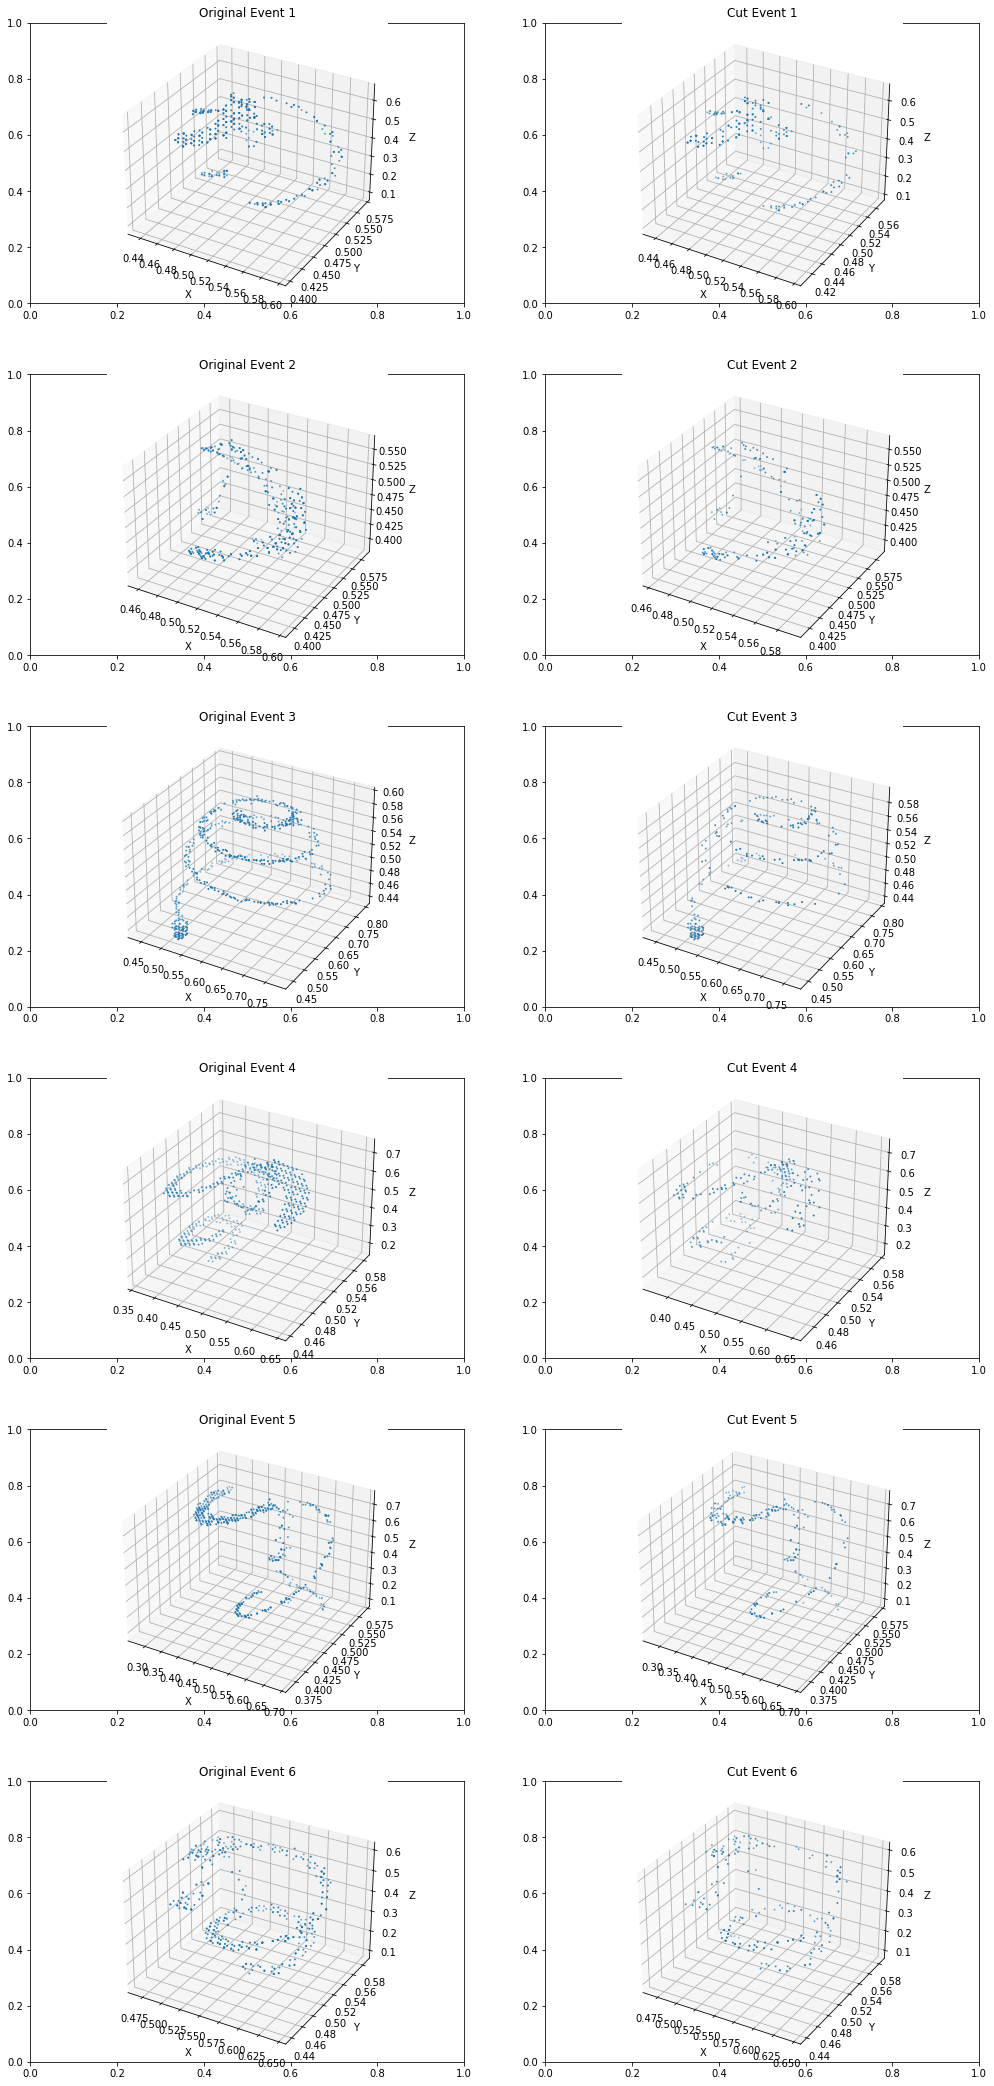

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function to handle operations for a single file
def process_and_plot(file_path, nCut):
    # Load the data from the file
    data = np.load(file_path)
    
    # Pick 6 random events from the data
    rng = np.random.default_rng()
    random_indices = rng.choice(data.shape[0], 6, replace=False)
    random_events = data[random_indices]
    
    # Initialize the figure for plotting
    fig, axs = plt.subplots(6, 2, figsize=(15, 30))
    fig.tight_layout(pad=5.0)
    
    for i, event in enumerate(random_events):
        # Perform the random cut on the event
        cut_event = random_cut(event, nCut)
        
        # Plot the original event
        axs[i, 0].set_title(f'Original Event {i+1}')
        axs[i, 0] = fig.add_subplot(6, 2, i*2 + 1, projection='3d')
        axs[i, 0].scatter(event[:, 0], event[:, 1], event[:, 2], s=1)
        axs[i, 0].set_xlabel('X')
        axs[i, 0].set_ylabel('Y')
        axs[i, 0].set_zlabel('Z')
        
        # Plot the cut event
        axs[i, 1].set_title(f'Cut Event {i+1}')
        axs[i, 1] = fig.add_subplot(6, 2, i*2 + 2, projection='3d')
        axs[i, 1].scatter(cut_event[:, 0], cut_event[:, 1], cut_event[:, 2], s=1)
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Y')
        axs[i, 1].set_zlabel('Z')
    
    plt.show()

# Define the random_cut function as provided
def random_cut(event, nSliced):
    rng = np.random.default_rng()
    slice_idx = int(rng.random() * len(event))
    # Ensure no out of bounds indexing
    while slice_idx > (len(event) - nSliced):
        slice_idx = int(rng.random() * len(event))
    last_idx = slice_idx + nSliced
    return np.delete(event, np.s_[slice_idx:last_idx], axis=0)

# Define the file path and nCut for testing the function
file_path = root+ 'Mg22_size512_convertXYZQ_train.npy'  # Update the file path accordingly
nCut = 300

# Call the function to process and plot the data for the specified file
process_and_plot(file_path, nCut)  # Commented out to prevent errors due to incorrect file path


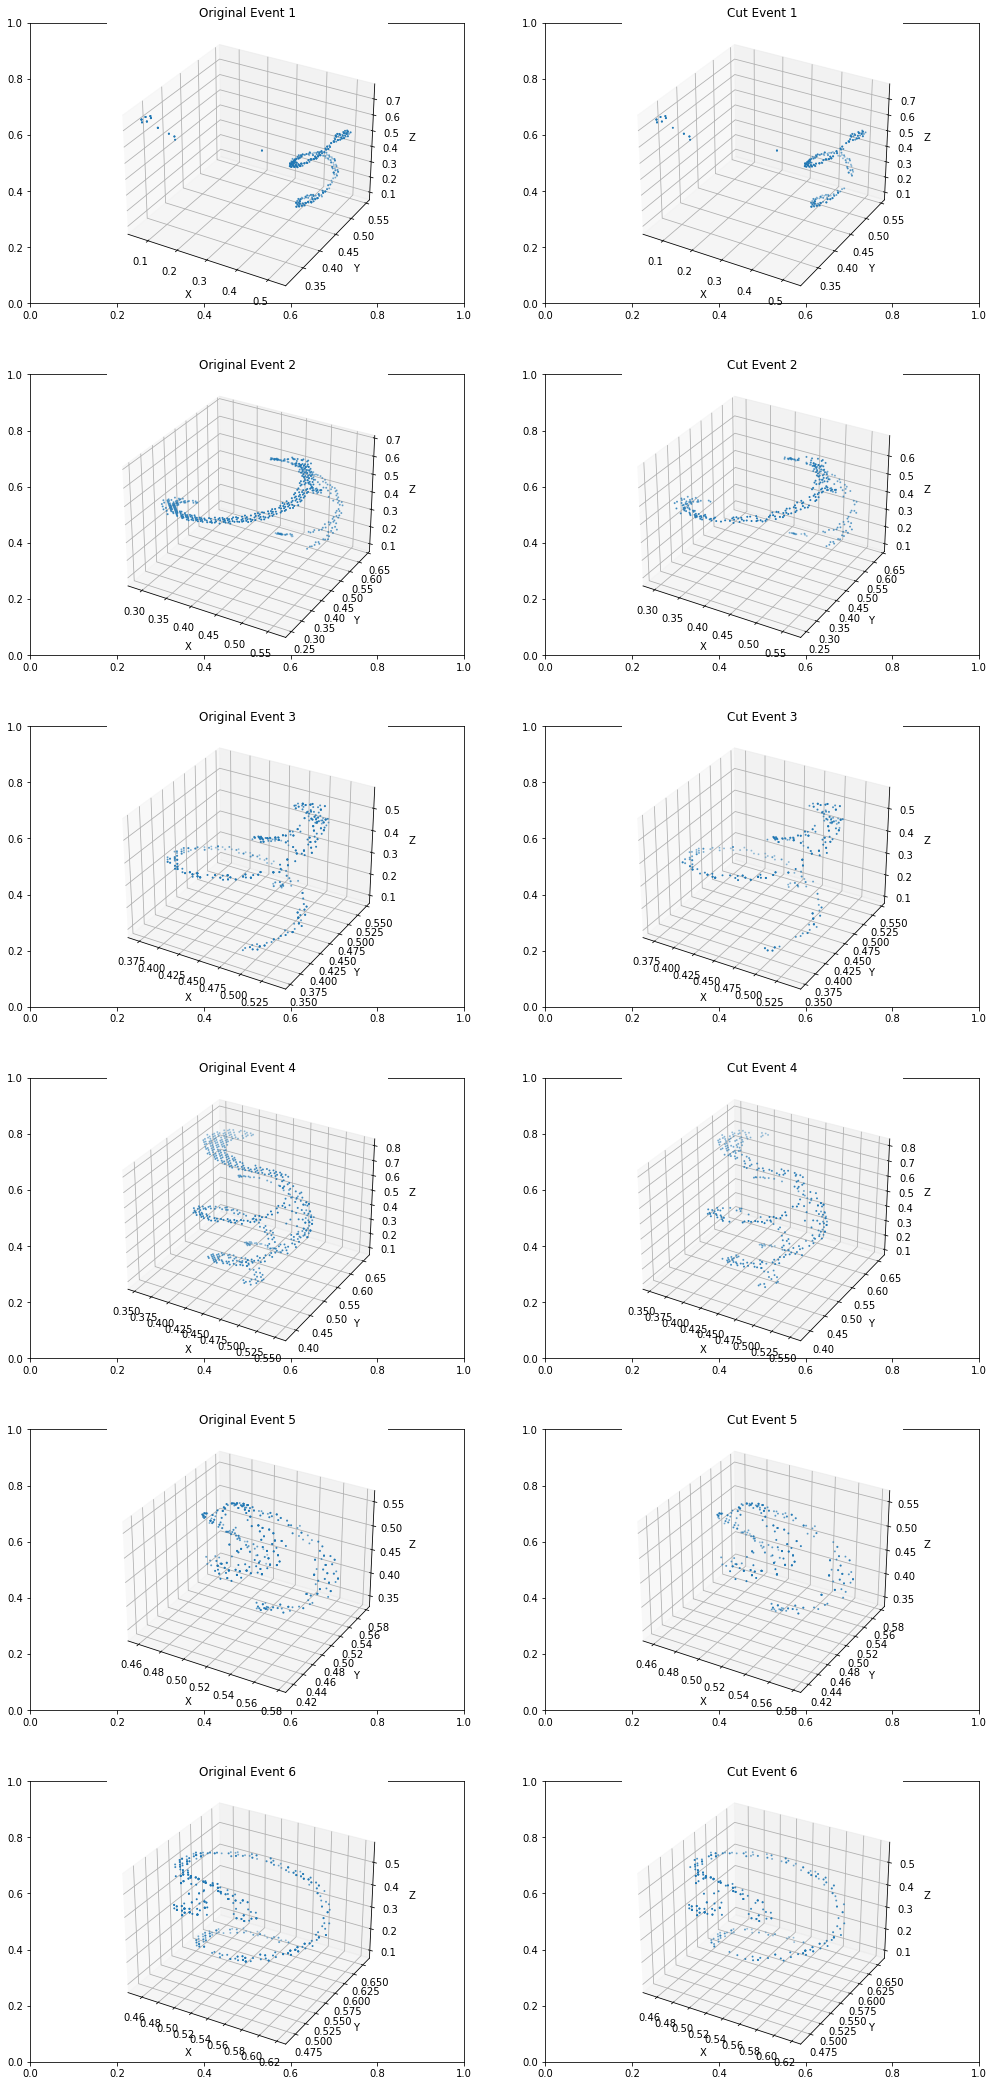

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the random_chunk_cut function
def random_chunk_cut(event, nChunks, chunkSize):
    rng = np.random.default_rng()
    total_length = len(event)
    chunk_starts = []
    for i in range(nChunks):
        slice_idx = int(rng.random() * total_length)
        while slice_idx > (total_length - chunkSize) or any(abs(start - slice_idx) < chunkSize for start in chunk_starts):
            slice_idx = int(rng.random() * total_length)
        chunk_starts.append(slice_idx)
    chunk_starts.sort(reverse=True)
    for start in chunk_starts:
        end = start + chunkSize
        event = np.delete(event, np.s_[start:end], axis=0)
    return event

# Define the function to handle operations for a single file
def process_and_plot(file_path, nChunks, chunkSize):
    data = np.load(file_path)
    rng = np.random.default_rng()
    random_indices = rng.choice(data.shape[0], 6, replace=False)
    random_events = data[random_indices]
    fig, axs = plt.subplots(6, 2, figsize=(15, 30))
    fig.tight_layout(pad=5.0)
    for i, event in enumerate(random_events):
        cut_event = random_chunk_cut(event, nChunks, chunkSize)
        axs[i, 0].set_title(f'Original Event {i+1}')
        axs[i, 0] = fig.add_subplot(6, 2, i*2 + 1, projection='3d')
        axs[i, 0].scatter(event[:, 0], event[:, 1], event[:, 2], s=1)
        axs[i, 0].set_xlabel('X')
        axs[i, 0].set_ylabel('Y')
        axs[i, 0].set_zlabel('Z')
        axs[i, 1].set_title(f'Cut Event {i+1}')
        axs[i, 1] = fig.add_subplot(6, 2, i*2 + 2, projection='3d')
        axs[i, 1].scatter(cut_event[:, 0], cut_event[:, 1], cut_event[:, 2], s=1)
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Y')
        axs[i, 1].set_zlabel('Z')
    plt.show()

# Define the file path, nChunks, and chunkSize for testing the function
file_path = root + 'Mg22_size512_convertXYZQ_train.npy'  # Update the file path accordingly
nChunks = 2
chunkSize = 100

# Call the function to process and plot the data for the specified file
process_and_plot(file_path, nChunks, chunkSize)  # Commented out to prevent errors due to incorrect file path


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 7 and the array at index 1 has size 3

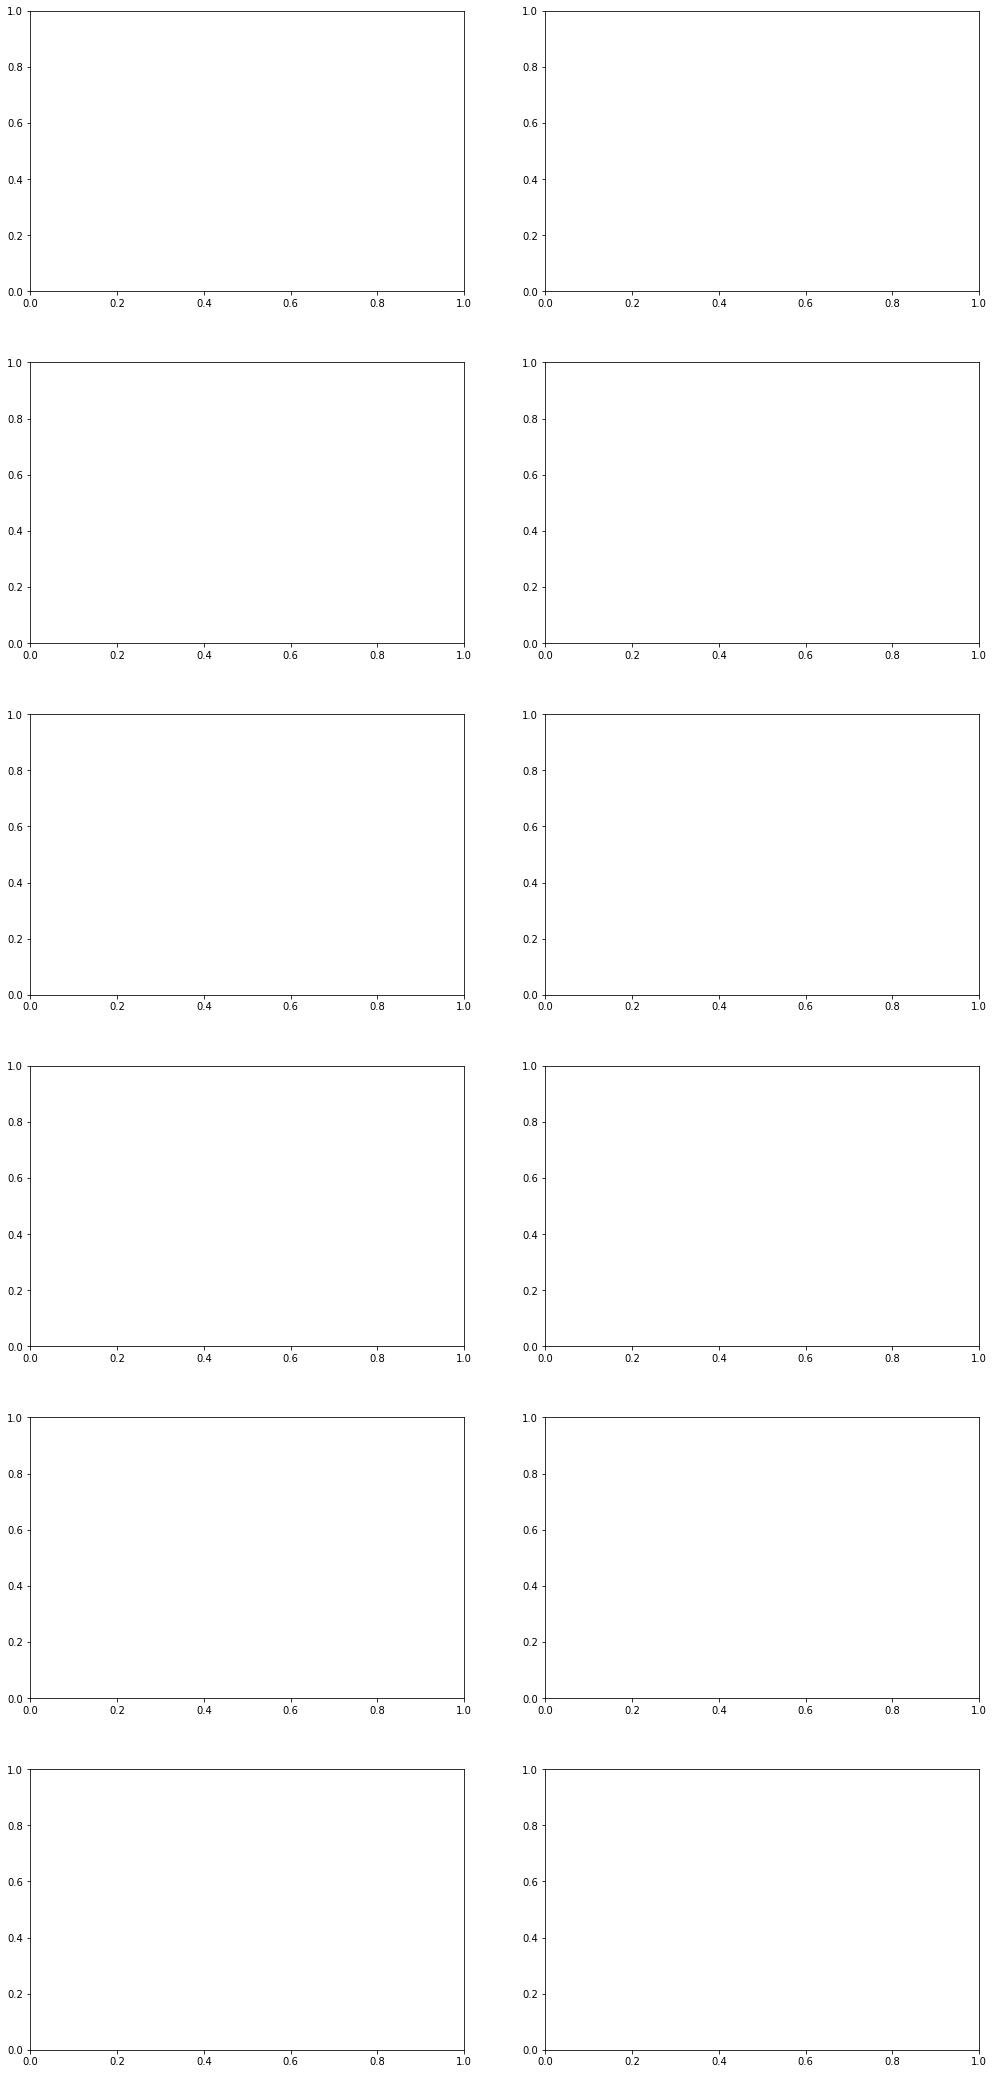

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def random_chunk_cut(event, nChunks, zRange):
    rng = np.random.default_rng()
    total_length = len(event)
    z_values = event[:, 2]
    min_z, max_z = np.min(z_values), np.max(z_values)
    
    # Ensure the zRange is smaller than the total z range
    if zRange >= (max_z - min_z):
        raise ValueError(f"zRange {zRange} is too large for the z range of the event ({min_z}, {max_z})")
    
    # Generate random starting Z values for each chunk
    chunk_starts_z = rng.uniform(min_z, max_z - zRange + 1, nChunks)  # adjusted line
    
    # Sort the chunk starts in descending order to handle deletion without index conflicts
    chunk_starts_z.sort()
    
    # Cut away chunks based on the Z range
    for start_z in chunk_starts_z:
        end_z = start_z + zRange
        chunk_indices = np.where((z_values >= start_z) & (z_values <= end_z))
        event = np.delete(event, chunk_indices, axis=0)
        z_values = np.delete(z_values, chunk_indices, axis=0)  # Update z_values array to keep it in sync with event array
    
    return event


# Corrected process_and_plot function
def process_and_plot(file_path, nChunks, zRange, nRandomPoints):
    data = np.load(file_path)
    rng = np.random.default_rng()
    random_indices = rng.choice(data.shape[0], 6, replace=False)
    random_events = data[random_indices]
    fig, axs = plt.subplots(6, 2, figsize=(15, 30))
    fig.tight_layout(pad=5.0)
    for i, event in enumerate(random_events):
        cut_event = random_chunk_cut(event, nChunks, zRange)  # Use new random_chunk_cut function
        augmented_event = add_random_points(cut_event, nRandomPoints)  # Add random points to the cut event
        axs[i, 0].set_title(f'Original Event {i+1}')
        axs[i, 0] = fig.add_subplot(6, 2, i*2 + 1, projection='3d')
        axs[i, 0].scatter(event[:, 0], event[:, 1], event[:, 2], s=1)
        axs[i, 0].set_xlabel('X')
        axs[i, 0].set_ylabel('Y')
        axs[i, 0].set_zlabel('Z')
        axs[i, 1].set_title(f'Augmented Event {i+1}')
        axs[i, 1] = fig.add_subplot(6, 2, i*2 + 2, projection='3d')
        axs[i, 1].scatter(augmented_event[:, 0], augmented_event[:, 1], augmented_event[:, 2], s=1)
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Y')
        axs[i, 1].set_zlabel('Z')
    plt.show()
    
def add_random_points(event, nRandomPoints):
    rng = np.random.default_rng()
    min_x, max_x = np.min(event[:, 0]), np.max(event[:, 0])
    min_y, max_y = np.min(event[:, 1]), np.max(event[:, 1])
    min_z, max_z = np.min(event[:, 2]), np.max(event[:, 2])
    
    # Generate random points within the range of existing points
    random_points_x = rng.uniform(min_x, max_x, nRandomPoints)
    random_points_y = rng.uniform(min_y, max_y, nRandomPoints)
    random_points_z = rng.uniform(min_z, max_z, nRandomPoints)
    
    # Combine the random points into a single array
    random_points = np.stack((random_points_x, random_points_y, random_points_z), axis=-1)
    
    # Concatenate the random points with the existing event points
    augmented_event = np.vstack((event, random_points))
    
    return augmented_event



# Define the file path, nChunks, and chunkSize for testing the function
file_path = root + 'Mg22_size512_convertXYZQ_train.npy'  # Update the file path accordingly
nChunks = 2
nRandomPoints = 100

# Define the Z range for identifying chunks
zRange = 0.1
# Call the process_and_plot function with the updated file path and cutting parameters
process_and_plot(file_path, nChunks, zRange, nRandomPoints)
